In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
#import pprint
from sklearn.preprocessing import LabelEncoder
import pydotplus #pip install pydotplus
from sklearn.tree import export_graphviz
from sklearn.model_selection import TimeSeriesSplit, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
# Models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from time import time

In [2]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

In [15]:
# Time test
%%timeit
df_train.MSSubClass+df_train.LotArea**2

757 µs ± 15 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [30]:
#df_train.head(3).T

In [31]:
#df_train.info()

In [32]:
#df_test.info()

In [33]:
print("# of unique columns in train set {}".format(df_train.columns.nunique()))
print("# of unique columns in test set {}".format(df_test.columns.nunique()))

# of unique columns in train set 81
# of unique columns in test set 80


In [34]:
types_columns = [str(df_train[str(x)].dtype) for x in list(df_test.columns)]

Check if there is any column with identical elements?

In [35]:
cols_to_drop = [col for col in df_train.columns if df_train[col].nunique(dropna=False) == 1]
cols_to_drop

[]

# Let's treat null values

### a) Train set

Do we have nan values?

In [36]:
print(df_train.isnull().any().any())
print("# of null elements in train set: ", df_train.isnull().sum().sum())
print("# of null elements in test set: ", df_test.isnull().sum().sum())
#nan_rows = df_train[df_train['name column'].isnull()] # #ow with nun
cols_with_null = [idx for idx,val in zip(df_train.isnull().any().index,
                                         df_train.isnull().any()) if val == True]

True
# of null elements in train set:  6965
# of null elements in test set:  7000


In [37]:
#print(cols_with_null)

In [38]:
#Firstly we will use zeros and means and modes for empty cells
df_train["LotFrontage"].fillna(0, inplace=True) # Numeric
df_train["Alley"].fillna('None', inplace=True) # Categorical
df_train["MasVnrType"].fillna('None', inplace=True) # Categ
df_train["MasVnrArea"].fillna(df_train["MasVnrArea"].mean(), inplace=True) # ? 
df_train["BsmtQual"].fillna('None', inplace=True) # or NA?
df_train["BsmtCond"].fillna('None', inplace=True) # or NA?
df_train["BsmtExposure"].fillna('None', inplace=True) # or NA?
df_train["BsmtFinType1"].fillna('None', inplace=True) # or NA?
df_train["BsmtFinType2"].fillna('None', inplace=True) # or NA?
df_train["Electrical"].fillna(df_train["Electrical"].mode().values[0], inplace=True) # or NA?
df_train["FireplaceQu"].fillna("None", inplace=True) # or NA?
df_train["GarageType"].fillna("None", inplace=True) # or NA?
df_train["GarageYrBlt"].fillna(df_train["GarageYrBlt"].mode().values[0], inplace=True) # or NA?  
df_train["GarageFinish"].fillna('None', inplace=True) # or NA?  
df_train["GarageQual"].fillna('None', inplace=True) # or NA?  
df_train["GarageCond"].fillna('None', inplace=True) # or NA?  
df_train["PoolQC"].fillna('None', inplace=True) # or NA?  
df_train["Fence"].fillna('None', inplace=True) # or NA?  
df_train["MiscFeature"].fillna('None', inplace=True) # or NA?  

### b) Test set

In [39]:
df_test["MSZoning"].fillna(df_train["MSZoning"].mode().values[0], inplace=True)
df_test["LotFrontage"].fillna(0, inplace=True) # Numeric
df_test["Alley"].fillna('None', inplace=True) # Categorical
df_test["Utilities"].fillna(df_train["Utilities"].mode().values[0], inplace=True)
df_test["Exterior1st"].fillna(df_train["Exterior1st"].values[0], inplace=True)
df_test["Exterior2nd"].fillna(df_train["Exterior2nd"].values[0], inplace=True)
df_test["MasVnrType"].fillna("None", inplace=True)
df_test["MasVnrArea"].fillna(df_train["MasVnrArea"].mean(), inplace=True) # train mean?
df_test["BsmtQual"].fillna('None', inplace=True) # or NA?
df_test["BsmtCond"].fillna('None', inplace=True) # or NA?
df_test["BsmtExposure"].fillna('None', inplace=True) # or NA?
df_test["BsmtFinType1"].fillna('None', inplace=True) # or NA?
df_test["BsmtFinType2"].fillna('None', inplace=True) # or NA?
df_test["BsmtFinSF1"].fillna(df_train["BsmtFinSF1"].mean(), inplace=True) # train mean?
df_test["BsmtFinSF2"].fillna(df_train["BsmtFinSF2"].mean(), inplace=True) # train mean?
df_test["BsmtUnfSF"].fillna(df_train["BsmtUnfSF"].mean(), inplace=True) # train mean?
df_test["TotalBsmtSF"].fillna(df_train["TotalBsmtSF"].mean(), inplace=True) # train mean?
df_test["BsmtFullBath"].fillna(0, inplace=True) 
df_test["BsmtHalfBath"].fillna(0, inplace=True) 
df_test["KitchenQual"].fillna(df_train["KitchenQual"].mode().values[0], inplace=True) # train mean?
df_test["Functional"].fillna(df_train["Functional"].mode().values[0], inplace=True) # train mean?
df_test["FireplaceQu"].fillna(df_train["FireplaceQu"].mode().values[0], inplace=True) # train mean?
df_test["GarageType"].fillna("None", inplace=True) 
df_test["GarageYrBlt"].fillna(df_train["GarageYrBlt"].mode().values[0], inplace=True) # train mean?
df_test["GarageFinish"].fillna("None", inplace=True)
df_test["GarageCars"].fillna("None", inplace=True) 
df_test["GarageArea"].fillna("None", inplace=True) 
df_test["GarageQual"].fillna("None", inplace=True) 
df_test["GarageCond"].fillna("None", inplace=True) 
df_test["PoolQC"].fillna("None", inplace=True) 
df_test["Fence"].fillna("None", inplace=True) 
df_test["MiscFeature"].fillna("None", inplace=True)
df_test["SaleType"].fillna(df_train["SaleType"].mode().values[0], inplace=True) 

### Data Processing

In [40]:
#df_train.info()

Price distplot

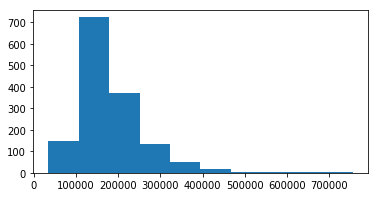

In [41]:
plt.figure(figsize=(6, 3))
plt.hist(df_train.
         loc[df_train['SalePrice'].
             isna() == False, 'SalePrice']);

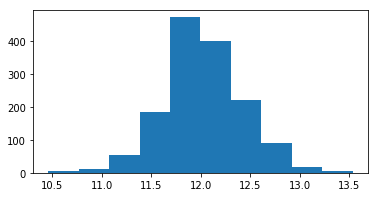

In [42]:
#log
plt.figure(figsize=(6, 3))
plt.hist(np.log1p(df_train.
                  loc[df_train['SalePrice'].
                      isna() == False, 'SalePrice']));
#plt.title("Random forest, MSE = %.2f" % np.sum((y_test - rf_predict) ** 2));

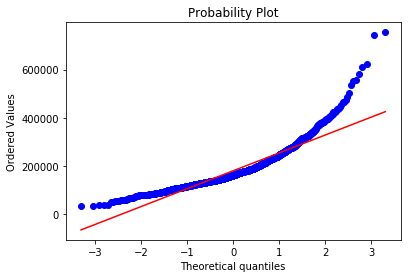

In [43]:
# statplots
from scipy import stats
res = stats.probplot(df_train['SalePrice'], plot=plt)

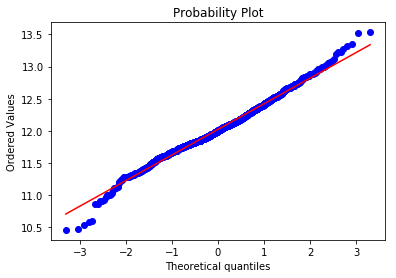

In [44]:
# log
# So, it must be better to log scale as it more analytical? So what?
res = stats.probplot(np.log1p(df_train['SalePrice']), plot=plt)

### Conversion to categorical data

In [45]:
cat_cols = []
for col in set(list(df_train.columns)+list(df_test.columns)).difference(["SalePrice"]):
    #print(df_train[str(col)].dtype)
    if str(df_train[str(col)].dtype) == "object" or str(df_test[str(col)].dtype) == "object":
        cat_cols.append(col)

In [46]:
for col in cat_cols:
    #print(col)
    lbl = LabelEncoder() # transform str to numbers
    lbl.fit(list(df_train[col].values.astype('str')) + list(df_test[col].values.astype('str')))
    df_train[col] = lbl.transform(list(df_train[col].values.astype('str')))
    df_test[col] = lbl.transform(list(df_test[col].values.astype('str')))
# it seems OK

Log of price

In [47]:
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])

### Decision Tree

In [48]:
x_train = df_train.drop(["Id","SalePrice"], axis=1) # drop indeces, convert to numeric
y_train = df_train["SalePrice"]

In [167]:
reg_tree = DecisionTreeRegressor(max_depth=20, random_state=17)
reg_tree.fit(x_train, y_train)
reg_tree_pred = reg_tree.predict(df_test.drop("Id",axis=1))

Postprocessing

In [164]:
def tree_graph_to_png(tree, feature_names, png_file_to_save):
    tree_str = export_graphviz(tree, feature_names=feature_names, 
                                     filled=True, out_file=None)
    graph = pydotplus.graph_from_dot_data(tree_str)  
    graph.write_png(png_file_to_save)

In [158]:
# Image creation
tree_graph_to_png(tree=reg_tree, feature_names=df_test.drop("Id",axis=1).columns, 
                  png_file_to_save='topic3_tree1.png')

### Light GBM

In [175]:
params = {"objective" : "regression", "metric" : "rmse", "max_depth": 9, "min_child_samples": 20, "reg_alpha": 0.2, "reg_lambda": 0.2,
        "num_leaves" : 257, "learning_rate" : 0.005, "subsample" : 0.9, "colsample_bytree" : 0.9, "subsample_freq ": 10}
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=False, random_state=42)
# Cleaning and defining parameters for LGBM
model = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)

In [182]:
X = df_train.drop(["Id", "SalePrice"], axis = 1)
y = df_train["SalePrice"]

prediction = np.zeros(df_test.shape[0])

for fold_n, (train_index, test_index) in enumerate(folds.split(X)):
    print('Fold:', fold_n)
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    

    model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
            verbose=500, early_stopping_rounds=100)
    
    y_pred = model.predict(df_test.drop("Id", axis=1), num_iteration=model.best_iteration_)
    prediction += y_pred
prediction /= n_fold

Fold: 0
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 0.105875	valid_1's rmse: 0.135763
[1000]	training's rmse: 0.0742598	valid_1's rmse: 0.12418
[1500]	training's rmse: 0.0620341	valid_1's rmse: 0.123503
[2000]	training's rmse: 0.0536299	valid_1's rmse: 0.122837
[2500]	training's rmse: 0.0468406	valid_1's rmse: 0.122337
[3000]	training's rmse: 0.0412277	valid_1's rmse: 0.121944
Early stopping, best iteration is:
[3192]	training's rmse: 0.039316	valid_1's rmse: 0.12188
Fold: 1
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 0.100454	valid_1's rmse: 0.161086
[1000]	training's rmse: 0.0682468	valid_1's rmse: 0.147716
[1500]	training's rmse: 0.0557288	valid_1's rmse: 0.146525
Early stopping, best iteration is:
[1559]	training's rmse: 0.0544858	valid_1's rmse: 0.146469
Fold: 2
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 0.104028	valid_1's rmse: 0.156388
[1000]	training's 

### Random Forest Regressor

In [120]:
#Note: Bagging reminds of the RF as well

# The main difference between random forests and bagging is that,
# in a random forest, the best feature for a split is selected from
# a random subset of the available features while, in bagging,
# all features are considered for the next best split.

In [49]:
x_train = df_train.drop(["Id","SalePrice"], axis=1) # drop indeces, convert to numeric
y_train = df_train["SalePrice"]

a) Simple alg

In [101]:
rf = RandomForestRegressor(n_estimators=10).fit(x_train, y_train)
rf_pred = rf.predict(df_test.drop("Id",axis=1))

In [102]:
rf_pred[rf_pred < 0]=0

In [103]:
rf_pred

array([11.73742618, 11.95386535, 12.13713822, ..., 11.86745066,
       11.58154863, 12.3886988 ])

b) More advanced + cross validation?

In [50]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Initialize a stratified split of our dataset for the validation process
# Create 5 datasets
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
"""
   It works only for classification problem?
    
   From docs:
   For integer/None inputs, if the estimator is a classifier
   and y is either binary or multiclass, StratifiedKFold is used.
   In all other cases, KFold is used.
"""

# Initialize the regressor with the default parameters 
rfr = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, oob_score=False)
rfr_fit = rfr.fit(x_train, y_train)

# ? 
dt_scores = cross_val_score(rfr_fit, x_train, y_train, cv=5)
print("mean cross validation score: {}".format(np.mean(dt_scores)))
print("score without cv: {}".format(rfr_fit.score(x_train, y_train)))

# WTF bitch?

mean cross validation score: 0.8714405571743798
score without cv: 0.9821771772681734


In [ ]:
rf_pred = rfr.predict(df_test.drop("Id",axis=1))

In [147]:
rf_pred[rf_pred<0] = 0

In [192]:
rf_pred = rfr.predict(df_test.drop("Id",axis=1))
rf_pred[rf_pred<0] = 0

c) With KFold and without cross_val_score #?

In [54]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Initialize a stratified split of our dataset for the validation process
# Create 5 datasets
folds = KFold(n_splits=5, shuffle=True, random_state=42)

train_acc = []
test_acc = []

rfr = RandomForestRegressor(n_estimators=100, random_state=42,
                            n_jobs=-1, oob_score=True)
for train_idx, test_idx in folds.split(x_train, y_train):
    X_train_, X_test_ = x_train.iloc[train_idx], x_train.iloc[test_idx]
    y_train_, y_test_ = y_train.iloc[train_idx], y_train.iloc[test_idx]
    rfr.fit(X_train_, y_train_)
    train_acc.append(rfr.score(X_train_, y_train_))
    test_acc.append(rfr.score(X_test_, y_test_))
    
print("Best accuracy on CV is {:.2f}".format(max(test_acc)*100))

Best accuracy on CV is 89.53


In [192]:
rf_pred = rfr.predict(df_test.drop("Id",axis=1))
rf_pred[rf_pred<0] = 0

d) KFold with cross_val_score

In [57]:
# Create 5 datasets
folds = KFold(n_splits=5, shuffle=True, random_state=42)

rfr = RandomForestRegressor(n_estimators=100, random_state=42,
                            n_jobs=-1, oob_score=True)

results = cross_val_score(rfr, x_train, y_train, cv=folds)
print("CV accuracy score: {:.2f}%".format(results.mean()*100))

CV accuracy score: 86.50%


e) tree_grid optimization

In [82]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Initialize a stratified split of our dataset for the validation process
# Create 5 datasets
folds = KFold(n_splits=5, shuffle=True, random_state=42)

train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []

trees_grid = [5, 10, 15, 20, 30, 50, 75, 100]

for ntrees in trees_grid:
    temp_train_acc = []
    temp_test_acc = []
    rfr = RandomForestRegressor(n_estimators=ntrees, random_state=42,
                                n_jobs=-1, oob_score=False)
    for train_idx, test_idx in folds.split(x_train, y_train):
        X_train_, X_test_ = x_train.iloc[train_idx], x_train.iloc[test_idx]
        y_train_, y_test_ = y_train.iloc[train_idx], y_train.iloc[test_idx]
        rfr.fit(X_train_, y_train_)
        temp_train_acc.append(rfr.score(X_train_, y_train_))
        temp_test_acc.append(rfr.score(X_test_, y_test_))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} trees".
      format(max(test_acc.mean(axis=1))*100,\
             trees_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 86.59% with 50 trees


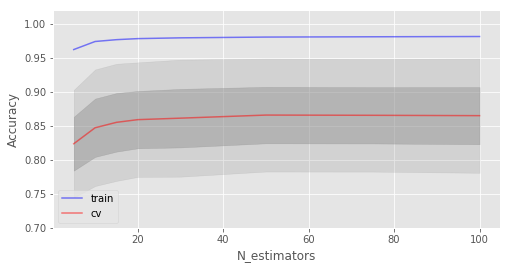

In [83]:
# Use this kind of plot somewhere else
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(trees_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(trees_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(trees_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(trees_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.70,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("N_estimators");

Feature importance

Feature ranking:
1. OverallQual 0.548957 
2. GrLivArea 0.102565 
3. TotalBsmtSF 0.052472 
4. GarageCars 0.045945 
5. 1stFlrSF 0.022011 
6. BsmtFinSF1 0.018500 
7. GarageType 0.016004 
8. YearBuilt 0.015455 
9. GarageArea 0.015214 
10. LotArea 0.015002 


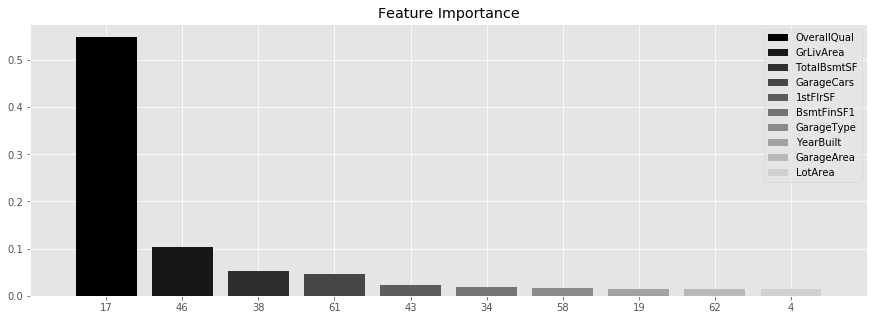

In [88]:
#Check it!
importances = rfr.feature_importances_

indices = np.argsort(importances)[::-1]

num_to_plot = 10
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

# Print the feature ranking
print("Feature ranking:")
  
for f in range(num_to_plot):
    print("%d. %s %f " % (f + 1, 
            df_train.columns[feature_indices[f]], 
            importances[indices[f]]))
plt.figure(figsize=(15,5))
plt.title(u"Feature Importance")
bars = plt.bar(range(num_to_plot), 
               importances[indices[:num_to_plot]],
       color=([str(i/float(num_to_plot+1)) 
               for i in range(num_to_plot)]),
               align="center")
ticks = plt.xticks(range(num_to_plot), 
                   feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u''.join(df_train.columns[i]) 
                  for i in feature_indices]);

f) GridSearch to find the optimal parameters

In [79]:
# Initialize the set of parameters for exhaustive search and fit 
parameters = {'max_features': [4, 7, 10, 13],
              'min_samples_leaf': [1, 3, 5, 7],
              'max_depth': [5,10,15,20]}
rfr = RandomForestRegressor(n_estimators=100, random_state=42, 
                             n_jobs=-1, oob_score=False)
gcv = GridSearchCV(rfr, parameters, n_jobs=-1, cv=KFold, verbose=1)
gcv.fit(x_train, y_train)

# what the fuck? n_splits

AttributeError: 'DataFrame' object has no attribute 'n_splits'

### Submission

In [193]:
sub = pd.DataFrame(data={"SalePrice":np.expm1(rf_pred)})
sub["Id"] = df_test["Id"].copy(deep=True)
sub.set_index("Id", inplace=True) # Set id as index

sub.to_csv("sub.csv", index=True)

# End of submission